In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# An Exercise:  2 x 3 x 2 Neural Network

For the purpose of mastering the concept of gradient descent and the backpropagation algorithm,  we will extend the previous examples by programming from scratch a neural network with 2 input layers, 3 hidden layers and 2 output layers. Again, we will be using simple variables to store the activations and derivatives instead of using vectors (next lecture). The purpose of writing the code in this simplified manner is to make the concepts as clear as possible, and show how they relate with the mathematical equations. __For that reason, code will deliberately be inefficient, and shouldn't be used for any serious application__.

The data and labels we will be using is the same as before:

In [2]:
data = np.array([[ 1.2, 0.7],
                 [-0.3,-0.5],
                 [ 3.0, 0.1],
                 [-0.1,-1.0],
                 [-0.0, 1.1],
                 [ 2.1,-1.3],
                 [ 3.1,-1.8],
                 [ 1.1,-0.1],
                 [ 1.5,-2.2],
                 [ 4.0,-1.0]])

In [3]:
labels = np.array([  'red',
                     'blue',
                     'red',
                     'blue',
                     'blue',
                     'red',
                     'blue',
                     'red',
                     'blue',
                     'blue'])

Here is the illustration of the neural network we will be using:

<img src="img/neural_networks_26.png" alt="drawing" width="950"/>

#### Task 1:

Write a function `convert_label(label)`, which converts the textual labels to probabilistic:

Test this function with some values from `labels`:

Write a function `forward_pass` that takes as an input all weights and biases and the current data point, and returns the function's output as a tuple `(O1, O2)`:

### The Algorithm

Let us first initialise the helper functions:

In [4]:
def plot_data(data, labels):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.scatter(data[:,0], data[:,1], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    nudge = 0.08
    for i, d in enumerate(data):
        ax.annotate(f'{i}',(d[0]+nudge,d[1]+nudge))
    ax.set_aspect('equal', 'datalim')
    plt.show()
    
def create_meshgrid(data):
    h = 0.02
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return (xx,yy,np.ones(xx.shape))

def eval_accuracy_neural(params, data, labels):
    A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5 = params
    num_correct = 0;
    
    for (X,Y),label_old in zip(data,labels):
        score = circuit_forward(A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5,X,Y)
        sc = np.array((int(score[0]>0.5),int(score[1]>0.5)))
        true_label = convert_label(label_old)
        if (sc[0]==true_label[0] and sc[1]==true_label[1]):
            num_correct += 1
    return num_correct / len(data)

def plot_neural_simple(params, grid,data, labels, iteration, accuracy):
    nudge = 0.06
    A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5 = params
    xx,yy,Z = grid
    
    for i in range(xx.shape[0]): # row
        for j in range(yy.shape[1]): #column
            X, Y = xx[i][j],yy[i][j]
            output = circuit_forward(A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5,X,Y) 
            score = 1 if np.argmax(output)==0 else -1
            Z[i][j] = score
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.title(f'accuracy at the iteration {iteration}: {accuracy}')
    ax.contourf(xx, yy, Z, cmap=plt.cm.binary, alpha=0.1, zorder=15)
    ax.scatter(data[:, 0], data[:, 1], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    ax.set_aspect('equal')
    for i, d in enumerate(data):
        ax.annotate(f'{i}',(d[0]+nudge,d[1]+nudge))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
    
def sigmoid(x):
    return 1/(1+np.exp(-x))

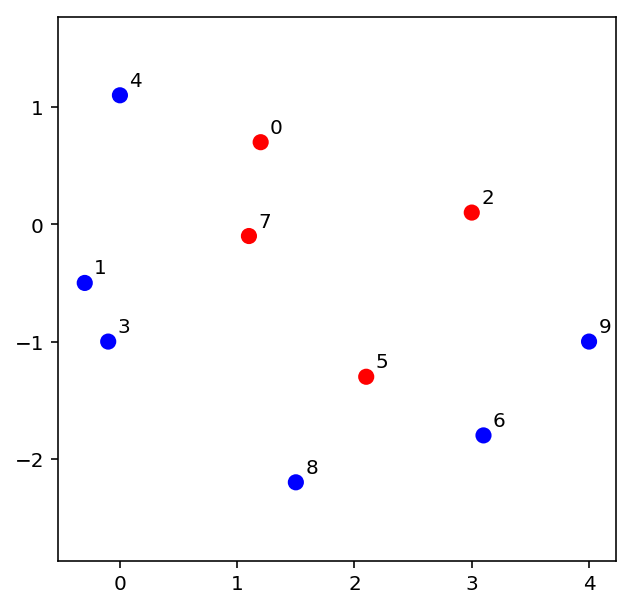

In [5]:
plot_data(data, labels)

Like before, the algorithm is extremely simplified and inefficiant in order to show clearly the internals of the calculation. Let's initialise the parameters of the network. This be done very efficiently with matrices, but here for the sake of clarifying the procedure we will initialise them manually with normally distributed random values between 0 and 1:

In [6]:
def train_neural_network(data, labels, step_size, epochs, iter_info):
    # for visualisation purposes only
    grid = create_meshgrid(data)
    # first we initialise all the weights and biases as normally distributed random numbers
    rnd = np.random.normal(size=17)
    # hidden layer
    # neuron 1
    A1, B1, C1 = rnd[0], rnd[1], rnd[2]
    # neuron 2
    A2, B2, C2 = rnd[3], rnd[4], rnd[5]
    # neuron 3
    A3, B3, C3 = rnd[6], rnd[7], rnd[8]
    # output layer
    # neuron 1
    A4, B4, C4, D4 = rnd[9], rnd[10], rnd[11], rnd[12]
    # neuron 2
    A5, B5, C5, D5 = rnd[13], rnd[14], rnd[15], rnd[16]

    # in each epoch, we will go through all the data points once
    for i in range (epochs):
        # total cost must be restarted in every epoch
        total_cost = 0.0
        ddA1, ddA2, ddA3, ddA4, ddA5, ddB1, ddB2, ddB3, ddB4, ddB5, ddC1, ddC2, ddC3, ddC4, ddC5, ddD4, ddD5 = np.zeros(17)
        # here we loop trough all the data points, and get X, Y and the corresponding label
        for index, ((X,Y), label_text) in enumerate(zip(data, labels)): 
            # forward pass
            N1 = sigmoid(A1*X + B1*Y + C1) # 1st neuron activation
            N2 = sigmoid(A2*X + B2*Y + C2) # 2nd neuron activation
            N3 = sigmoid(A3*X + B3*Y + C3) # 3rd neuron activation
            z1 = A4*N1 + B4*N2 + C4*N3 + D4 #intermediate step 1
            z2 = A5*N1 + B5*N2 + C5*N3 + D5 #intermediate step 2
            O1 = sigmoid(z1) # final activation 1
            O2 = sigmoid(z2) # final activation 2
            # convert the old labels -1 and 1 to tuples (1,0) and (0,1)
            label = convert_label(label_text)
            # This is the implementation of the quadratic cost for the single data point
            cost = (O1-label[0])**2 + (O2-label[1])**2
            # This value is then accumulated into total_cost variable, so that the cost is expressed
            # for all the data points
            total_cost += cost

            # backpropagating through the network
            # here we compute the derivative of the total cost TC in respect to the intermediate steps z1 and z2
            dz1 = 2*(O1-label[0])*O1*(1-O1)
            dz2 = 2*(O2-label[1])*O2*(1-O2)
            # computing the derivatives of the weights of the first neuron in the output layer
            dA4, dB4, dC4 = dz1*N1, dz1*N2, dz1*N3
            # computing the derivatives of the weights of the second neuron in the output layer
            dA5, dB5, dC5 = dz2*N1, dz2*N2, dz2*N3
            # computing the derivatives of the biases in both neurons of the output layer
            dD4, dD5 = dz1, dz2

            # computing the partials of the intermediate steps dz1, dz2, dz3 in respect to the activations N1, N2, N3
            dN1 = dz1*A4 + dz2*A5
            dN2 = dz1*B4 + dz2*B5
            dN3 = dz1*C4 + dz2*C5
            # computing the partials of the intermediate steps p1, p2 and p3
            dp1 = dN1*N1*(1-N1)
            dp2 = dN2*N2*(1-N2)
            dp3 = dN3*N3*(1-N3)
            # computing the partials of the total cost in respect to the biases C1, C2, C3
            dC1, dC2, dC3 = dp1, dp2, dp3
            # computing the partials of the total cost in respect to the weights A1, B1, A2, B2, C1, C2
            dA1, dA2, dA3 = dp1*X, dp2*X, dp3*X
            dB1, dB2, dB3 = dp1*Y, dp2*Y, dp3*Y        
            
            # since we have multiple data points, and we can compute only a single partial derivative at the time
            # we accumulate their values in the variables ddA1...ddD4
            ddA1 += dA1
            ddA2 += dA2
            ddA3 += dA3
            ddA4 += dA4
            ddA5 += dA5
            ddB1 += dB1
            ddB2 += dB2
            ddB3 += dB3
            ddB4 += dB4
            ddB5 += dB5
            ddC1 += dC1
            ddC2 += dC2
            ddC3 += dC3
            ddC4 += dC4
            ddC5 += dC5
            ddD4 += dD4
            ddD5 += dD5
            
        # Now we make an average of all the accumulated derivatives by dividing with the number of data points
        datalen = len(data)
        ddA1 /= datalen
        ddA2 /= datalen
        ddA3 /= datalen
        ddA4 /= datalen
        ddA5 /= datalen
        ddB1 /= datalen
        ddB2 /= datalen
        ddB3 /= datalen
        ddB4 /= datalen
        ddB5 /= datalen
        ddC1 /= datalen
        ddC2 /= datalen
        ddC3 /= datalen
        ddC4 /= datalen
        ddC5 /= datalen
        ddD4 /= datalen
        ddD5 /= datalen

        # finally, we do the parameter update with the averaged values ddA1...ddD4
        A1 -= ddA1 * step_size;
        B1 -= ddB1 * step_size; 
        C1 -= ddC1 * step_size;
        A2 -= ddA2 * step_size; 
        B2 -= ddB2 * step_size;
        C2 -= ddC2 * step_size;
        A3 -= ddA3 * step_size; 
        B3 -= ddB3 * step_size; 
        C3 -= ddC3 * step_size;
        A4 -= ddA4 * step_size; 
        B4 -= ddB4 * step_size; 
        C4 -= ddC4 * step_size;
        A5 -= ddA5 * step_size;
        B5 -= ddB5 * step_size;
        C5 -= ddC5 * step_size;
        D4 -= ddD4 * step_size;
        D5 -= ddD5 * step_size;

        if (i%iter_info==0):
            accuracy = eval_accuracy_neural((A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5),data,labels)
            plot_neural_simple((A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5),grid, data, labels, i, accuracy)
            print (f'total cost: {total_cost}\n')
            
    return (A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5)

In [7]:
params = train_neural_network(data, labels, 2, 301, 50)

NameError: name 'convert_label' is not defined

Inspect each data point's predicted vs true label

In [8]:
A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5 = params
for i, ((X,Y),label_text) in enumerate(zip(data,labels)):
    score = circuit_forward(A1,A2,A3,A4,A5,B1,B2,B3,B4,B5,C1,C2,C3,C4,C5,D4,D5,X,Y)
    label = convert_label(label_text)
    sc = (int(score[0]>=0.5),int(score[1]>=0.5))
    print (f'data point {i}: real label : {label}, pred. label: {sc}, {sc==label}')

NameError: name 'params' is not defined